In [384]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from tqdm import tqdm

In [314]:
# generate dataset from y = 2 + 3x
def sim_data(N = 500, b0 = 2, b1 = 3, runs = 1000):
    data = np.zeros(shape=(runs, N, 2))
    for i in range(runs):
        x = np.random.uniform(-2, 2, size=(N, 1))
        e = np.random.normal(0, 8, size=(N, 1))
        y = b0 + b1 * x + e  # y = 2x + 3 + E
        data[i] = np.column_stack((x, y))
    return data

In [419]:
# helper to create array of models
def make_models(alpha):
    return [LinearRegression(fit_intercept=True, normalize=True), 
            Ridge(fit_intercept=True, alpha=alpha, normalize=True, solver="saga"),
            Lasso(fit_intercept=True, alpha=alpha, normalize=True)]

# helper to generate data, fit models, cache results and return 
def do_pred(data, X_test, n=1000, alpha=0.5):
    models = make_models(alpha=alpha)
    coefs = np.zeros(shape=(n, len(models)))
    intercepts = np.zeros(shape=(n, len(models)))
    preds = np.zeros(shape=(n, len(models)))
    # for n iters, simulate data, fit model, get coeffs
    for i in range(len(data)):
        X = data[i, :, 0].reshape(-1 ,1)
        y = data[i, :, 1].reshape(-1, 1)
        for idx, model in enumerate(models):
            model.fit(X, y)
            preds[i, idx] = model.predict(X_test)
            coefs[i, idx] = float(model.coef_)
            intercepts[i, idx] = float(model.intercept_)
    return coefs, intercepts, preds

def compute_bv(preds, true):
    means = np.mean(preds, 0)
    bias = true - means
    variance = np.mean(np.abs(preds - means), 0)
    return bias, variance

# helper to plot, c is the coefficient array of size (N x 3)
def show_plot(p, alpha, filename=None):
    plt.figure(figsize=(10, 5))
    
    # plot distribution, colors from color brewer
    plt.hist(p[:, 0], label="OLS", alpha=0.5, bins=50, color="#2ca25f")
    plt.hist(p[:, 1], label="Ridge", alpha=0.5, bins=50, color="#e6550d")
    plt.hist(p[:, 2], label="Lasso", alpha=0.5, bins=50, color="#3182bd")
    
    # plot means of predictions 
    _means = np.mean(p, axis=0)
    plt.vlines(x=_means, ymin=0, ymax=80, linestyles="dashed", linewidth=2,
               colors=["#006d2c", "#a63603", "#08519c"])
    plt.vlines(x=11, ymin=0, ymax=80, linestyles="dashed", linewidth=2,
               colors="#737373", label="True")

    # final touches
    plt.ylim(0, 70)
    plt.legend(bbox_to_anchor=(1, 1))
    if alpha == "FAKE":
        ttl = "Fabricated distribution of predictions"
    else:
        ttl = "Distribution of prediction for lambda = {0}".format(alpha)
    plt.title(ttl)
    
    if filename:
        plt.savefig('./figures/{0}'.format(filename))
    plt.show()

In [328]:
data = sim_data()
X_test = np.array([[3]])

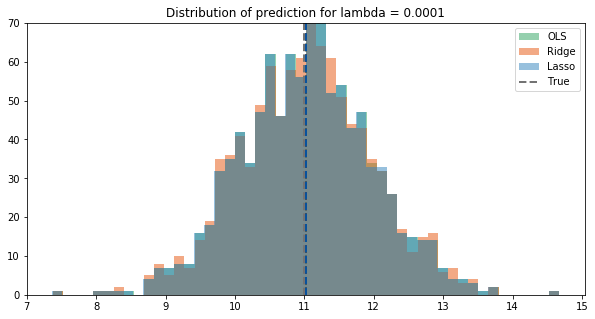

In [349]:
c, i, p = do_pred(data, X_test, alpha=0.0001)
show_plot(p, 0.0001, "l0_0001")

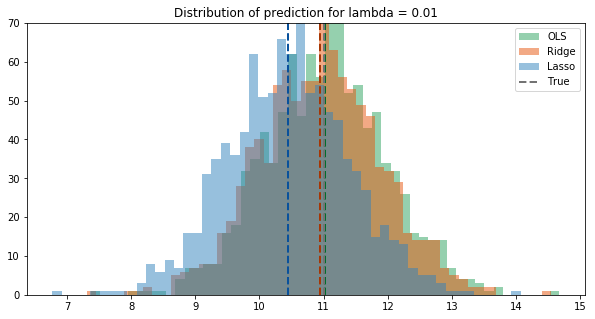

In [350]:
c, i, p = do_pred(data, X_test, alpha=0.01)
show_plot(p, 0.01, "l0_01")

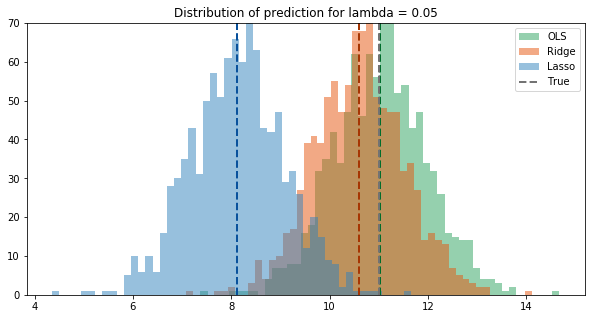

In [351]:
c, i, p = do_pred(data, X_test, alpha=0.05)
show_plot(p, 0.05, "l0_05")

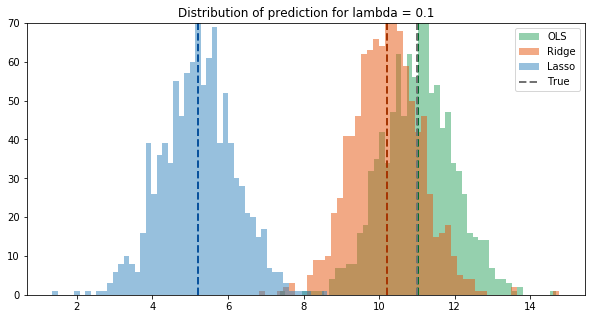

In [352]:
c, i, p = do_pred(data, X_test, alpha=0.1)
show_plot(p, 0.1, "l0_1")

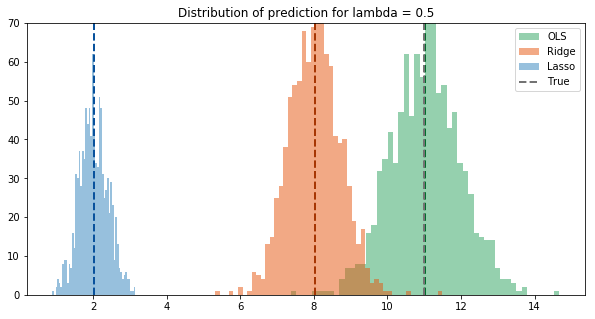

In [353]:
c, i, p = do_pred(data, X_test, alpha=0.5)
show_plot(p, 0.5, "l0_5")

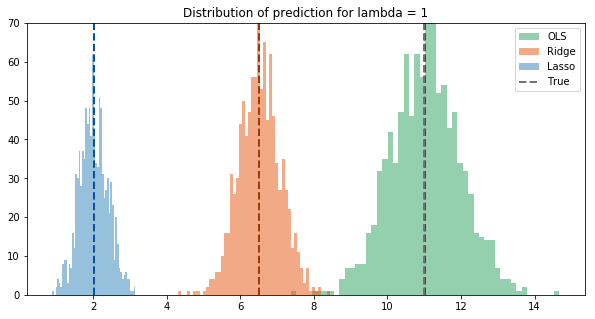

In [354]:
c, i, p = do_pred(data, X_test, alpha=1)
show_plot(p, 1, "l1")

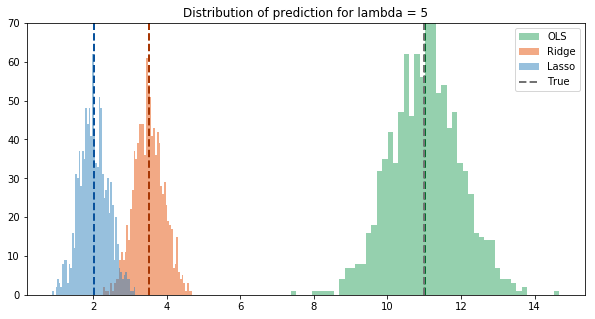

In [355]:
c, i, p = do_pred(data, X_test, alpha=5)
show_plot(p, 5, "l5")

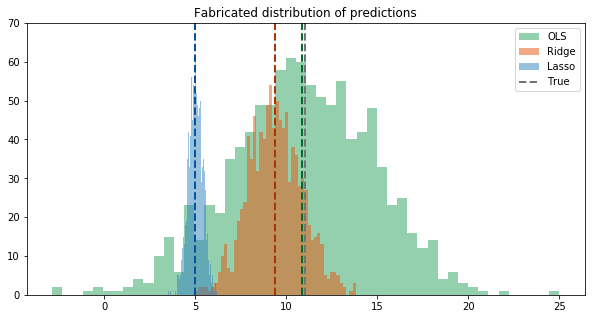

In [424]:
ols_fake = np.random.normal(11, 4, size=1000)
ridge_fake = np.random.normal(9.5, 1.5, size=1000)
lasso_fake = np.random.normal(5, 0.4, size=1000)
fake_data = np.column_stack((ols_fake, ridge_fake, lasso_fake))
show_plot(fake_data, "FAKE", "fabricated")

In [377]:
lambdas = np.linspace(0.0001, 1, 100)

In [382]:
bias = np.zeros(shape=(len(lambdas), 3))
variance = np.zeros(shape=(len(lambdas), 3))

In [385]:
for idx, _lambda in tqdm(enumerate(lambdas)):
    c, i, p = do_pred(data, X_test, alpha=_lambda)
    b, v = compute_bv(p, true=11)
    bias[idx, :] = b
    variance[idx, :] = v

100it [03:00,  1.84s/it]


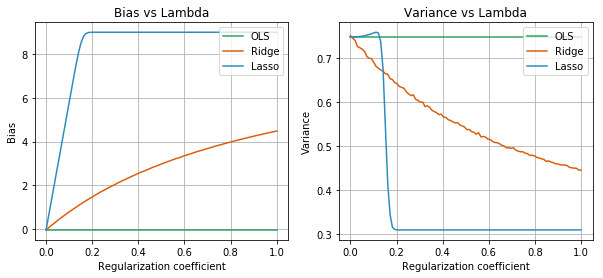

In [434]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(lambdas, bias[:, 0], label="OLS", color="#2ca25f")
plt.plot(lambdas, bias[:, 1], label="Ridge", color="#d95f0e")
plt.plot(lambdas, bias[:, 2], label="Lasso", color="#2b8cbe")
plt.xlabel("Regularization coefficient")
plt.ylabel("Bias")
plt.title("Bias vs Lambda")
plt.legend(loc="upper right")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(lambdas, variance[:, 0], label="OLS", color="#2ca25f")
plt.plot(lambdas, variance[:, 1], label="Ridge", color="#d95f0e")
plt.plot(lambdas, variance[:, 2], label="Lasso", color="#2b8cbe")
plt.xlabel("Regularization coefficient")
plt.ylabel("Variance")
plt.title("Variance vs Lambda")
plt.legend(loc="upper right")
plt.grid()
plt.savefig("./figures/bvplot.png")
plt.show()